<a href="https://colab.research.google.com/github/Vasanth12414/Deep-Learning-Models/blob/main/Brain_Tumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
#!/bin/bash
!kaggle datasets download masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/brain-tumor-mri-dataset.zip')
zip_ref.extractall('/content')
zip_ref.close()



In [4]:

DATADIR = '/content/Brain-Tumor'
CATEGORIES  = ['glioma','meningioma','notumor','pituitary','glioma_Test','meningioma_Test','notumor_Test','pituitary_Test']


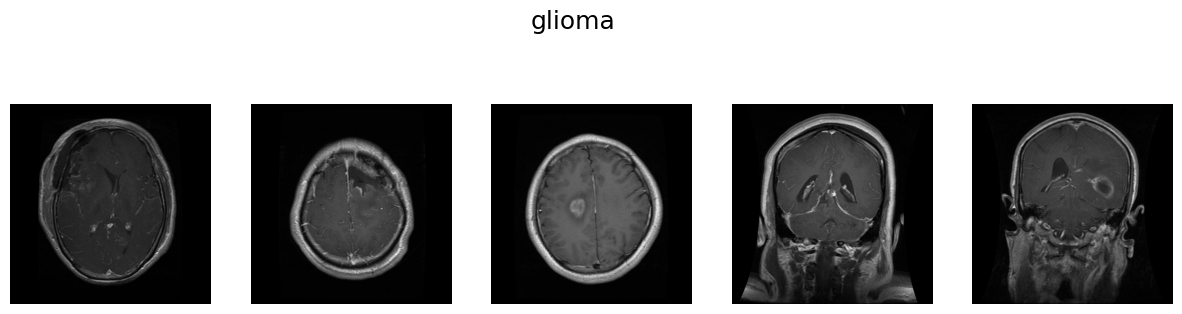

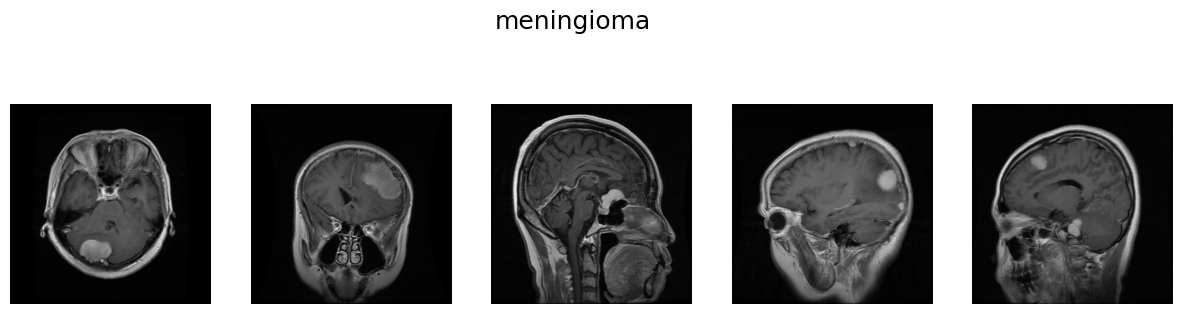

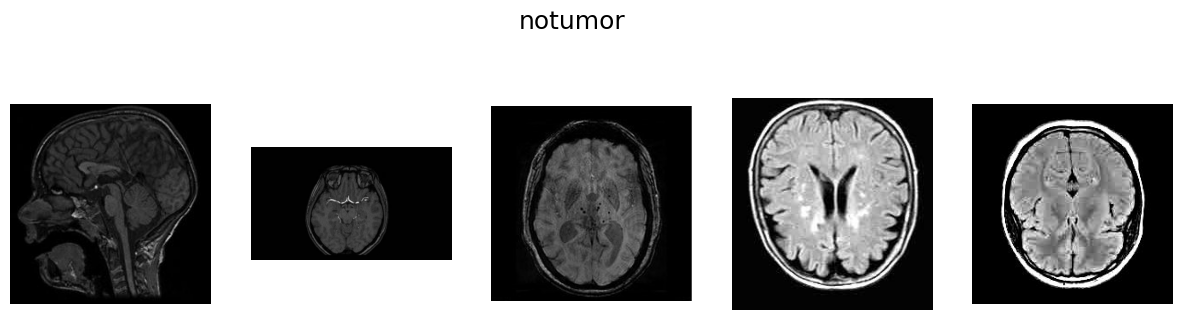

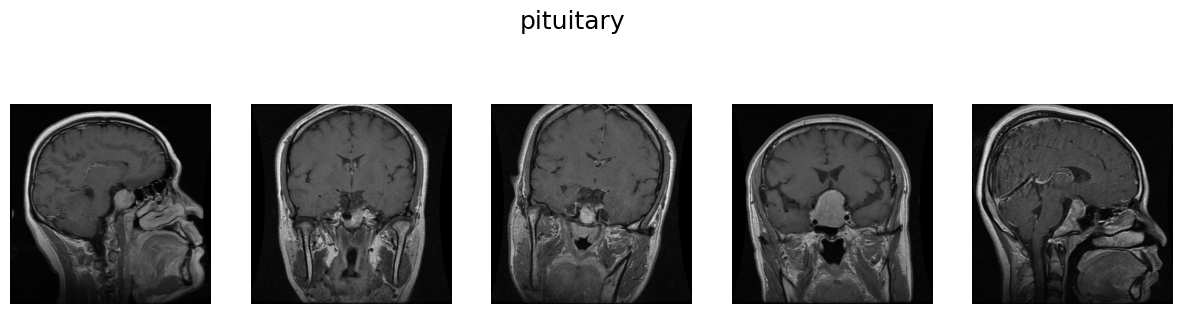

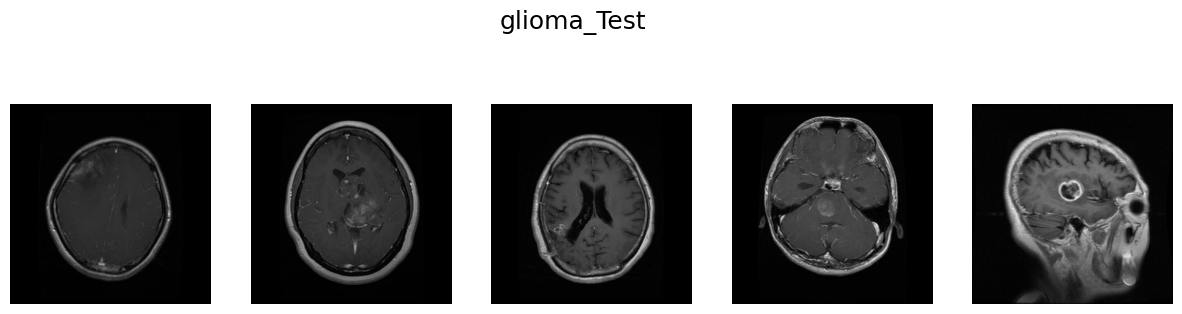

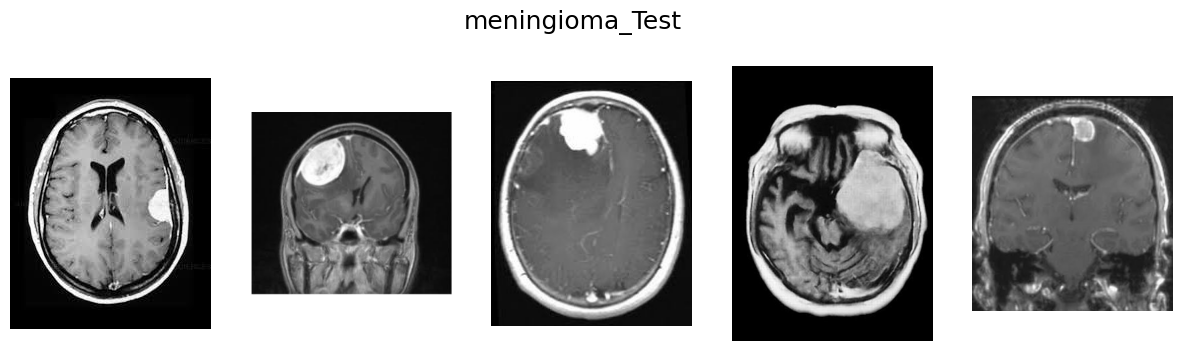

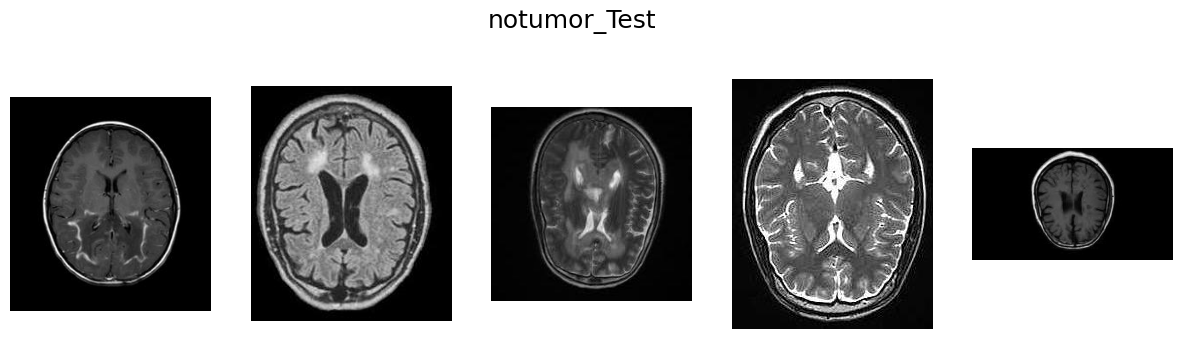

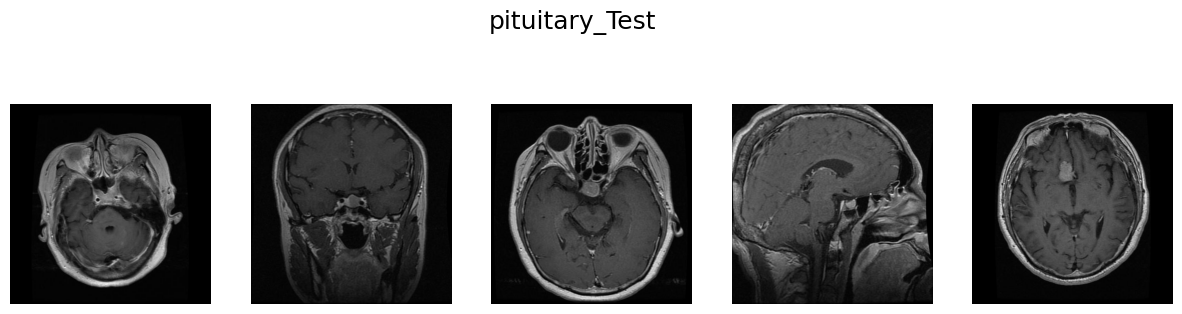

In [6]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2



DATADIR = '/content/Brain-Tumor'
CATEGORIES  = ['glioma','meningioma','notumor','pituitary','glioma_Test','meningioma_Test','notumor_Test','pituitary_Test']



for category in CATEGORIES:
    path = os.path.join(DATADIR,category)
    images = os.listdir(path)

    fig, axes = plt.subplots(1, 5, figsize=(15, 4))
    fig.suptitle(f'{category}', fontsize=18)

    for i in range(5):
        img_name = images[np.random.randint(0, len(images))]
        img_path = os.path.join(path, img_name)
        img_array = cv2.imread(img_path)

        axes[i].imshow(img_array)
        axes[i].axis('off')

    plt.show()

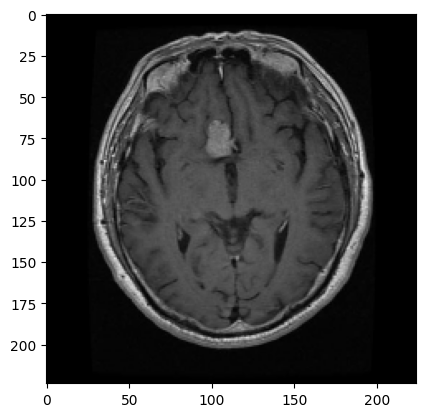

In [7]:
IMG_SIZE = 224
new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
plt.imshow(new_array)

In [9]:
import tensorflow as tf
import numpy as np
import os
import cv2
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

In [10]:
data_dir = "/content/Brain-Tumor"  # ✅ Set directory here
img_size = (224, 224)  # Required input size for EfficientNet
batch_size = 32  # Number of images per training batch

In [11]:
def cutout(image, mask_size=50, num_holes=2):
    """
    Applies Cutout augmentation by masking multiple random regions.
    """
    img_height, img_width, _ = image.shape
    mask_value = np.mean(image, axis=(0, 1))  # Mean pixel value as mask color

    for _ in range(num_holes):
        # Randomly select the cutout region center
        x = np.random.randint(img_width)
        y = np.random.randint(img_height)

        # Define the cutout region
        x1 = np.clip(x - mask_size // 2, 0, img_width)
        x2 = np.clip(x + mask_size // 2, 0, img_width)
        y1 = np.clip(y - mask_size // 2, 0, img_height)
        y2 = np.clip(y + mask_size // 2, 0, img_height)

        # Apply mean color mask (instead of black)
        image[y1:y2, x1:x2] = mask_value

    return image

In [12]:
def cutmix(batch_x, batch_y, alpha=1.0):
    """
    Applies CutMix augmentation by replacing a region of an image with a region from another image.
    """
    batch_size = len(batch_x)
    indices = np.random.permutation(batch_size)

    mixed_x = batch_x.copy()
    mixed_y = batch_y.copy()

    for i in range(batch_size):
        lam = np.random.beta(alpha, alpha)

        # Choose a random region for cutout
        img_h, img_w, _ = batch_x[i].shape
        cut_w = int(img_w * np.sqrt(1 - lam))
        cut_h = int(img_h * np.sqrt(1 - lam))

        cx = np.random.randint(img_w)
        cy = np.random.randint(img_h)

        x1 = np.clip(cx - cut_w // 2, 0, img_w)
        x2 = np.clip(cx + cut_w // 2, 0, img_w)
        y1 = np.clip(cy - cut_h // 2, 0, img_h)
        y2 = np.clip(cy + cut_h // 2, 0, img_h)

        # Replace cut region with a patch from another image
        mixed_x[i, y1:y2, x1:x2] = batch_x[indices[i], y1:y2, x1:x2]

        # Adjust label weights based on lambda
        lam_adjusted = 1 - ((x2 - x1) * (y2 - y1) / (img_w * img_h))
        mixed_y[i] = lam_adjusted * batch_y[i] + (1 - lam_adjusted) * batch_y[indices[i]]

    return mixed_x, mixed_y

# ✅ Generator function to apply CutMix
def cutmix_generator(generator, alpha=1.0):
   for batch_x, batch_y in generator:
        batch_x, batch_y = cutmix(batch_x, batch_y, alpha)
        yield batch_x, batch_y

In [13]:
datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.3,
    horizontal_flip=True,
    validation_split=0.2,
    preprocessing_function=lambda img: cutout(img, mask_size=50, num_holes=2)
)

In [14]:
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

# Validation Data (No CutMix applied)
val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 5620 images belonging to 8 classes.
Found 1403 images belonging to 8 classes.


In [15]:
train_generator_with_cutmix = cutmix_generator(train_generator)

In [16]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze last few layers for fine-tuning
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Add classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Convert feature maps to 1D vector
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Reduce overfitting
output_layer = Dense(train_generator.num_classes, activation='softmax')(x)  # Output layer

# Define the final model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Model Summary
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 4,709,547 (17.97 MB)

 Trainable params: 4,667,524 (17.81 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [17]:
epochs = 25  # Increased epochs for better training

model.fit(
    train_generator_with_cutmix,   # ✅ Apply CutMix
    validation_data=val_generator,
    epochs=epochs,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    verbose=1
)

Epoch 1/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 690ms/step - accuracy: 0.3680 - loss: 1.7783

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


176/176 ━━━━━━━━━━━━━━━━━━━━ 245s 943ms/step - accuracy: 0.3686 - loss: 1.7774 - val_accuracy: 0.0798 - val_loss: 2.1611
Epoch 2/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 99s 563ms/step - accuracy: 0.5958 - loss: 1.4081 - val_accuracy: 0.1924 - val_loss: 2.1026
Epoch 3/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 101s 575ms/step - accuracy: 0.6083 - loss: 1.3489 - val_accuracy: 0.2267 - val_loss: 2.0776
Epoch 4/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 102s 579ms/step - accuracy: 0.6208 - loss: 1.3109 - val_accuracy: 0.1867 - val_loss: 49.9499
Epoch 5/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 115s 655ms/step - accuracy: 0.6413 - loss: 1.2818 - val_accuracy: 0.2459 - val_loss: 2.0813
Epoch 6/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 109s 619ms/step - accuracy: 0.6571 - loss: 1.2306 - val_accuracy: 0.2473 - val_loss: 28.5165
Epoch 7/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 97s 553ms/step - accuracy: 0.6653 - loss: 1.2284 - val_accuracy: 0.1989 - val_loss: 55.9934
Epoch 8/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 98s 557ms/step - accuracy: 0.6674 - loss: 1.21